# Example: JUSTICE - IAM Simulation Run

In [1]:
import pandas as pd
import numpy as np

from src.util.data_loader import DataLoader
from src.util.enumerations import *
from src.util.model_time import TimeHorizon
from src.model import JUSTICE

/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setting Some Dummy Policy Levers

JUSTICE model has two policy levers: Savings rate and Emissions Control Rate. To run the simulation version of the model, we need to feed the policy levers with some values. The range of both savings rate and emissions control rate are from 0 to 1.0 corresponding to 0% to 100%. 

Here we set the savings rate to the intial savings rate data of the different regions and increase it linearly to the optimal savings rate of original DICE/RICE implementation

#### Lever: Fixed Savings rate

Savings rate array can be passed during initialization of JUSTICE. 
If not, fixed savings rate is used. For fixed savings rate, elasticity of marginal utility of consumption and pure rate of time preference is required during init.

(57, 58)


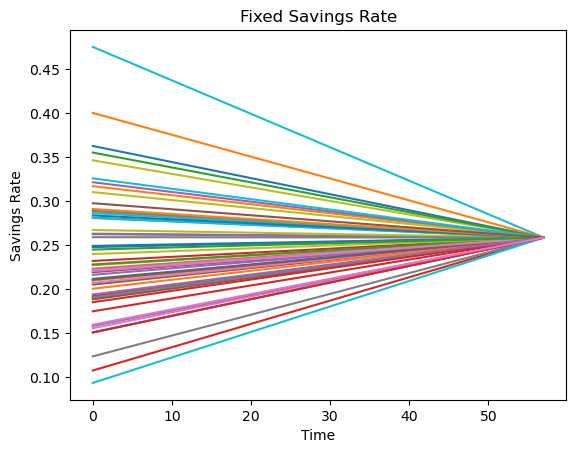

In [2]:
import matplotlib.pyplot as plt
# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

fixed_savings_rate = np.copy(data_loader.SAVING_RATE_INIT_ARRAY).reshape(-1, 1)
# fixed_savings_rate Validated with RICE50 for timestep 1 and 5

optimal_long_run_savings_rate = 0.2582781457 #self.get_optimal_long_run_savings_rate()
time = time_horizon.data_time_horizon
# for i, years in enumerate(set_year):
#for t in range(len(time_horizon.model_time_horizon))
for t in range(2, (len(time) + 1)):
    # t = i + 1  # index starts at 0, so add 1 to get the year
    # if t != 1:  # no need to repeat for the first year
    next_rate = data_loader.SAVING_RATE_INIT_ARRAY + (
        optimal_long_run_savings_rate - data_loader.SAVING_RATE_INIT_ARRAY
    ) * ((t - 1) / (len(time) - 1))
    # append to the fixed savings rate array for each year
    fixed_savings_rate = np.column_stack((fixed_savings_rate, next_rate))

# plot the savings rate
print(fixed_savings_rate.shape)
# Fixed savings rate is of shape (57,58) where 58 is the time horizon to be plotted on x axis. 57 are the different regions so loop through them
for i in range(fixed_savings_rate.shape[0]):
    plt.plot(fixed_savings_rate[i, :])

plt.title("Fixed Savings Rate")
plt.xlabel("Time")
plt.ylabel("Savings Rate")
plt.show()

#### Lever: Linear Emissions Control Rate

Here the emission control starts at 0, meaning no emission control and increases linearly to 100% emission control rate depending on the transistion start year and the full emission control year.

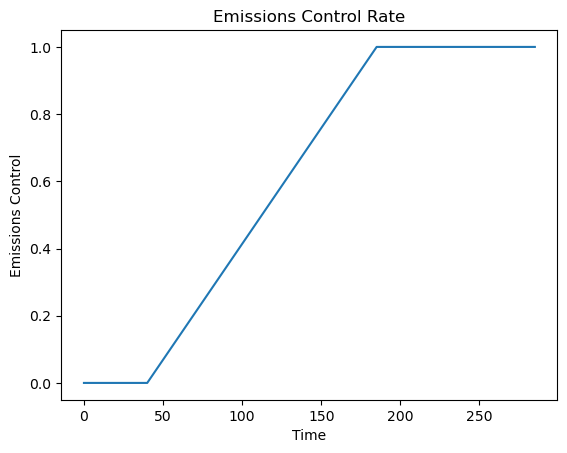

In [3]:
# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.0 #0.0 #1.0
min_miu_year = 2055 #9-original #8 in this model  # 2060
max_miu = 1.0
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu

# Current shape is (57,286). Convert it to (57,286, 1001) by repeating the same value for all 1001 emissions scenarios
# emissions_control_rate = np.tile(emissions_control_rate[:, :, np.newaxis], [1, 1, 1001])
# print(emissions_control_rate.shape)

from matplotlib import pyplot as plt
plt.plot(emissions_control_rate[0, :])
plt.title("Emissions Control Rate")
plt.xlabel("Time")
plt.ylabel("Emissions Control")
plt.show()

## 1. JUSTICE Initialisation

JUSTICE Runs on 8 SSP-RCP scenarios. The SSP-RCP scenarios can be seen with this piece of code

In [5]:
# Get list of Scenarios from Enum

for idx, scenarios in enumerate(list(Scenario.__members__.keys())):
    print(idx, scenarios)

0 SSP119
1 SSP126
2 SSP245
3 SSP370
4 SSP434
5 SSP460
6 SSP534
7 SSP585


Here we initiate the model with a scenario index corresponding to a particular SSP-RCP scenario. The scenario index is from 0 to 7. The scenario index is the same as the index of the SSP-RCP scenarios in the list above.

The initialization phase of JUSTICE loads all the economic and climate data, creates all the arrays to store the results and sets the initial values of the variables.

In [4]:
scenarios = 0
model = JUSTICE(
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
        social_welfare_function=WelfareFunction.UTILITARIAN,
        # climate_ensembles=570, # This is to select a specific climate ensemble
        # Following variables are optional
        elasticity_of_marginal_utility_of_consumption = 1.45,
        pure_rate_of_social_time_preference = 0.015, #0.015,
        inequality_aversion = 0.0,#0.5,
        sufficiency_threshold = 0.0, #0.4565625,
        egality_strictness = 0,
    )

## 2. Run

The run function runs the model for a particular scenario index with the given policy lever setting. The run function returns the results of the simulation.


In [5]:
model.run(emission_control_rate = emissions_control_rate, endogenous_savings_rate=True) #savings_rate = fixed_savings_rate, 

## 3. Evaluate - SWF - and Generated Output Datasets

Evaluation Phase Extracts the results from the simulation and also applies the social welfare function to compute the welfare

In [6]:
datasets = model.evaluate() #elasticity_of_marginal_utility_of_consumption = 1.45, pure_rate_of_social_time_preference = 0.015, inequality_aversion = 0.5

print(model.get_outcome_names()) # Get the list of outcomes from the simulation run

dict_keys(['gross_economic_output', 'net_economic_output', 'consumption', 'consumption_per_capita', 'emissions', 'regional_temperature', 'global_temperature', 'damage_fraction', 'economic_damage', 'abatement_cost', 'carbon_price', 'disentangled_utility', 'welfare_utilitarian_regional_temporal', 'welfare_utilitarian_regional', 'welfare_utilitarian_temporal', 'welfare_utilitarian'])


## 3.1 Stepwise Run & Evaluate

Instead of running the entire model horizon, we can run the model step by step. This is useful for integrating the model with EMODPS framework for adaptive policymaking or RL framework.

In [4]:
for timestep in range(len(time_horizon.model_time_horizon)):
    
    model.stepwise_run( emission_control_rate = emissions_control_rate[:, timestep], timestep=timestep, endogenous_savings_rate=True) #savings_rate = fixed_savings_rate[:, timestep],
    datasets = model.stepwise_evaluate(timestep=timestep)
    


Extracting the data from the outcome dictionary to the different variables

In [7]:
#Shape of disentangled_utility, disentangled_utility_summed, disentangled_utility_powered, welfare_utilitarian
# Shape of discount_rate
# (57, 286, 1)
#(57, 286, 1001) (286, 1001) (286, 1001) (286, 1001)
#(57, 286, 1001) (286, 1001) (286, 1001) (1001,)
# Shape of discount_rate
# (286, 1)
gross_output = datasets['gross_economic_output'] 
net_output = datasets['net_economic_output']
consumption = datasets['consumption'] #(57, 286, 1001)
cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis_control = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)
disentangled_utility = datasets['disentangled_utility'] #(57, 286, 1001)
welfare_utilitarian = datasets['welfare_utilitarian'] # (1001,)
welfare_utilitarian_temporal = datasets['welfare_utilitarian_temporal']  # (286, 1001)
welfare_utilitarian_regional = datasets['welfare_utilitarian_regional'] # (57, 1001)
welfare_utilitarian_regional_temporal = datasets['welfare_utilitarian_regional_temporal'] # (57, 286, 1001)



## 4. Visualize

We can visualize the timeseries of the different outcomes that we extracted in the previous step

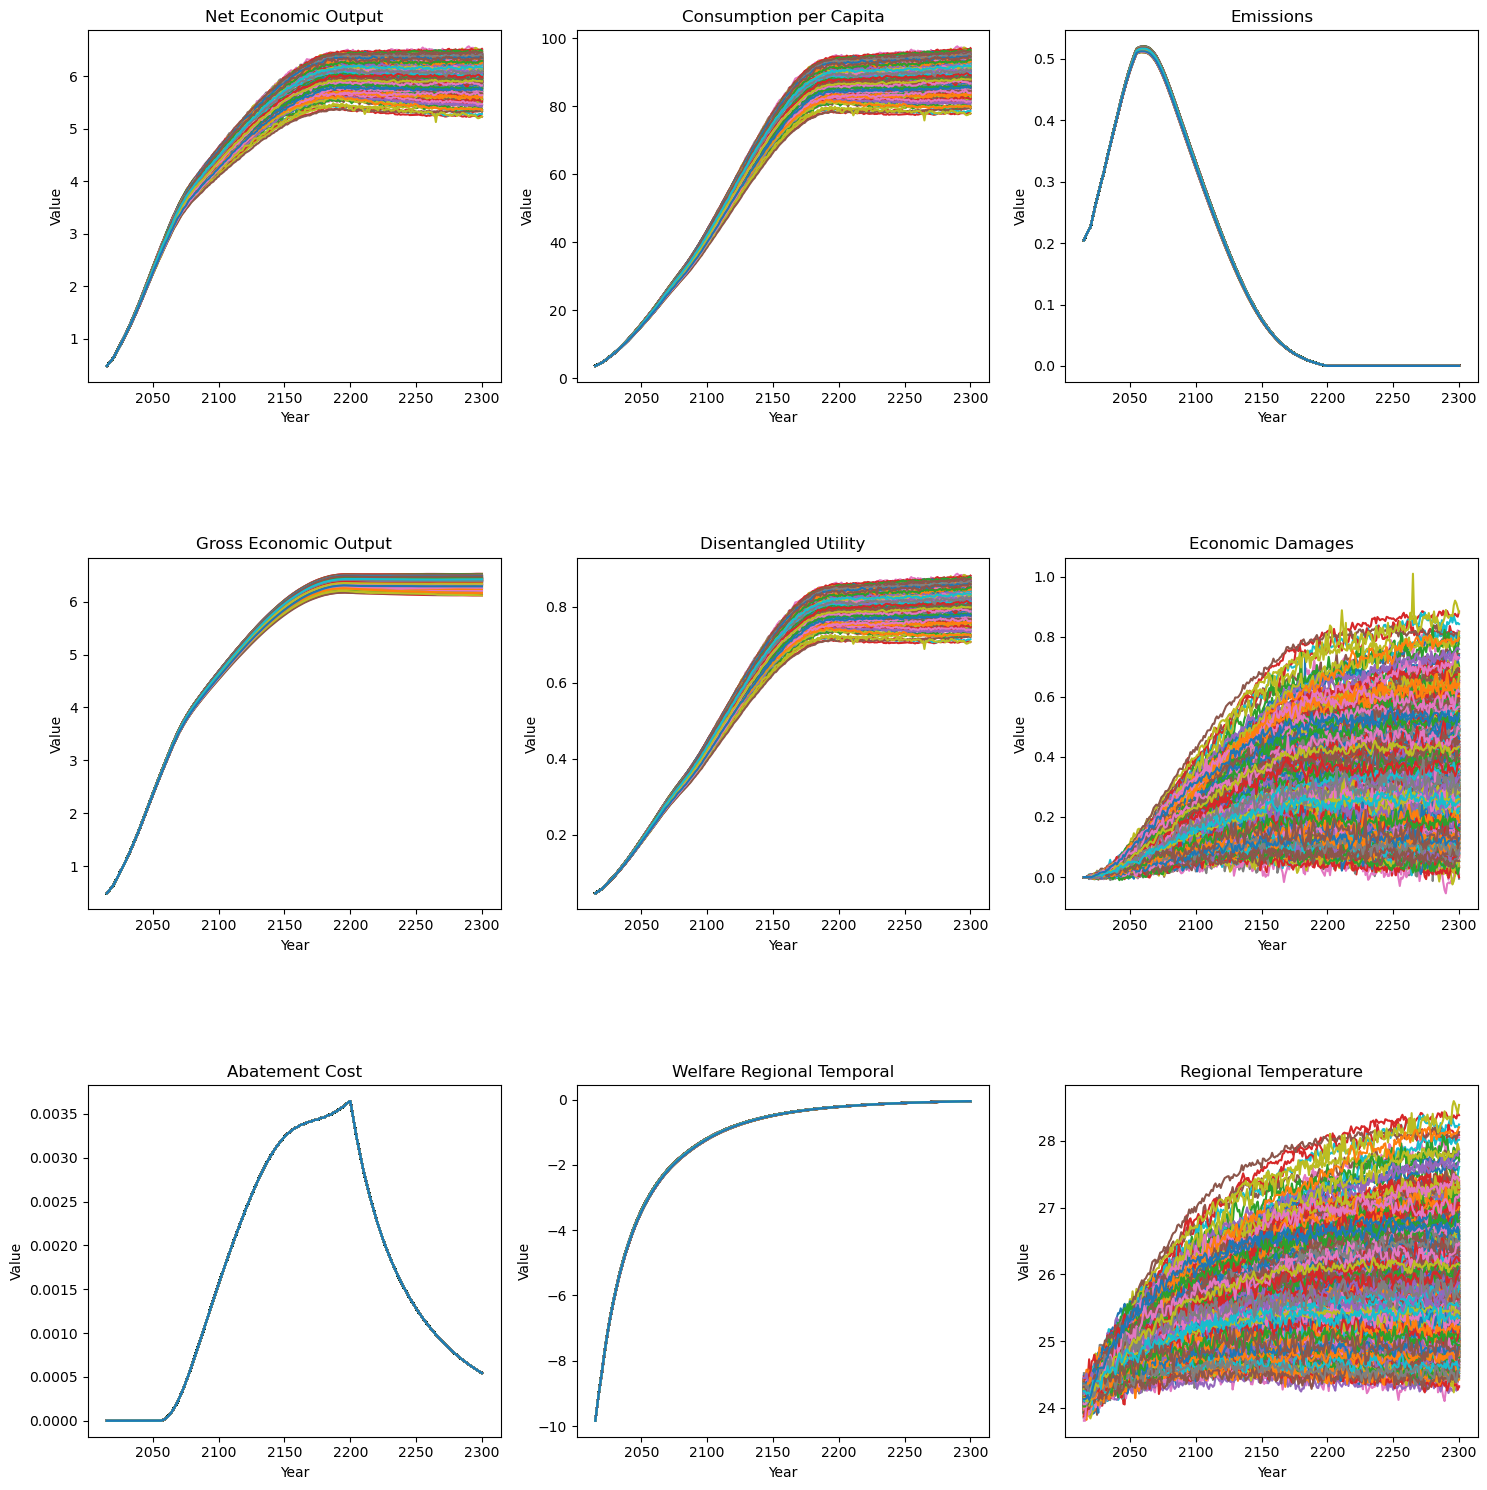

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create list of all the data arrays
data_list = [net_output, cpc, emis_control, gross_output, disentangled_utility, damages, abatecost, welfare_utilitarian_regional_temporal, reg_temp]
titles = ['Net Economic Output', 'Consumption per Capita', 'Emissions', 'Gross Economic Output','Disentangled Utility', 'Economic Damages', 'Abatement Cost', 'Welfare Regional Temporal', 'Regional Temperature']

region_index = 55

# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the data arrays and plot them
for i, data in enumerate(data_list):
    # Select the region based on region_index
    region_data = data[region_index, :, :]
    
    # Create a line plot for each scenario
    for j in range(region_data.shape[1]):
        sns.lineplot(x=time_horizon.model_time_horizon, y=region_data[:, j], ax=axs[i])
    
    # Set the title and axis labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')
    
# Remove the unused subplots
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)





## Run All Scenarios

In [5]:
# Create a dictionary to store the data for each scenario
scenario_data = {}


for idx, scenarios in enumerate(list(Scenario.__members__.keys())):
    print(idx, scenarios)
    
    # Initialize the model
    model = JUSTICE(
            scenario =idx,
            economy_type=Economy.NEOCLASSICAL,
            damage_function_type=DamageFunction.KALKUHL,
            abatement_type=Abatement.ENERDATA,
            social_welfare_function=WelfareFunction.UTILITARIAN,
            # Declaring for endogenous fixed savings rate
            elasticity_of_marginal_utility_of_consumption = 1.45,
            pure_rate_of_social_time_preference = 0.015,
        )
    
    # Run the model
    model.run(emission_control_rate = emissions_control_rate, endogenous_savings_rate=True)

    # elasticity_of_marginal_utility_of_consumption,
    # pure_rate_of_social_time_preference,
    # inequality_aversion,
    # Evaluate the model
    scenario_data[scenarios] = model.evaluate()


0 SSP119
1 SSP126
2 SSP245
3 SSP370
4 SSP434
5 SSP460
6 SSP534
7 SSP585


## The Codes after this point is for testing purpose. Not example codes.

# ______________________________________________________________________________________________________________________

## Main Analysis Starts Here

## Neural Networks Test for EMODPS

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the architecture of neural network
class Net(nn.Module):
    def __init__(self, input_size, output_size, first_layer_size, hidden_layers, hidden_layer_size, weights=None, biases=None):
        super(Net, self).__init__()
        self.first_layer = nn.Linear(input_size, first_layer_size)
        
        if weights is not None and biases is not None:
            self.first_layer.weight = nn.Parameter(torch.Tensor(weights[0]))
            self.first_layer.bias = nn.Parameter(torch.Tensor(biases[0]))
            
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_layers - 1):
            hidden_layer = nn.Linear(first_layer_size, hidden_layer_size)
            if weights is not None and biases is not None:
                hidden_layer.weight = nn.Parameter(torch.Tensor(weights[i+1]))
                hidden_layer.bias = nn.Parameter(torch.Tensor(biases[i+1]))
            self.hidden_layers.append(hidden_layer)
            
            first_layer_size = hidden_layer_size

        self.last_layer = nn.Linear(first_layer_size, output_size)

        if weights is not None and biases is not None:
            self.last_layer.weight = nn.Parameter(torch.Tensor(weights[-1]))
            self.last_layer.bias = nn.Parameter(torch.Tensor(biases[-1]))

    def forward(self, x):
        x = F.leaky_relu(self.first_layer(x), 0.1)
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x), 0.1)
        x = torch.sigmoid(self.last_layer(x))
        return x

In [ ]:
import numpy as np

# # Create a 57 by 57 matrix of value 0.5
# weights = np.full((57, 57), 0.5)
# # Create a shape (57) matrix of value 0.5
# biases = np.full((57), 0.5)
# Assumption - MOEA provides these values
layer_1_weights = np.full((57, 57), 0.5)  # replace with actual value from MOEA
layer_2_weights = np.full((57, 57), 0.5)  # replace with actual value from MOEA

layer_1_biases = np.full((57), 0.0)  # replace with actual value from MOEA
layer_2_biases = np.full((57), 0.0)  # replace with actual value from MOEA

# Stack them into lists
weights = [layer_1_weights, layer_2_weights]
biases = [layer_1_biases, layer_2_biases]

model = Net(input_size=57, output_size=57, first_layer_size=57, hidden_layers=1, hidden_layer_size=57, weights=weights, biases=biases)

In [ ]:
import numpy as np

# Create a 1 by 57 numpy array of 0.5s
input_data = np.full((1, 57), 0.2)

# Convert the numpy array to a torch tensor
input_data_tensor = torch.Tensor(input_data)

# Pass the tensor through the model
output = model(input_data_tensor)

output = output.detach().numpy()

# Print the output
print(output)

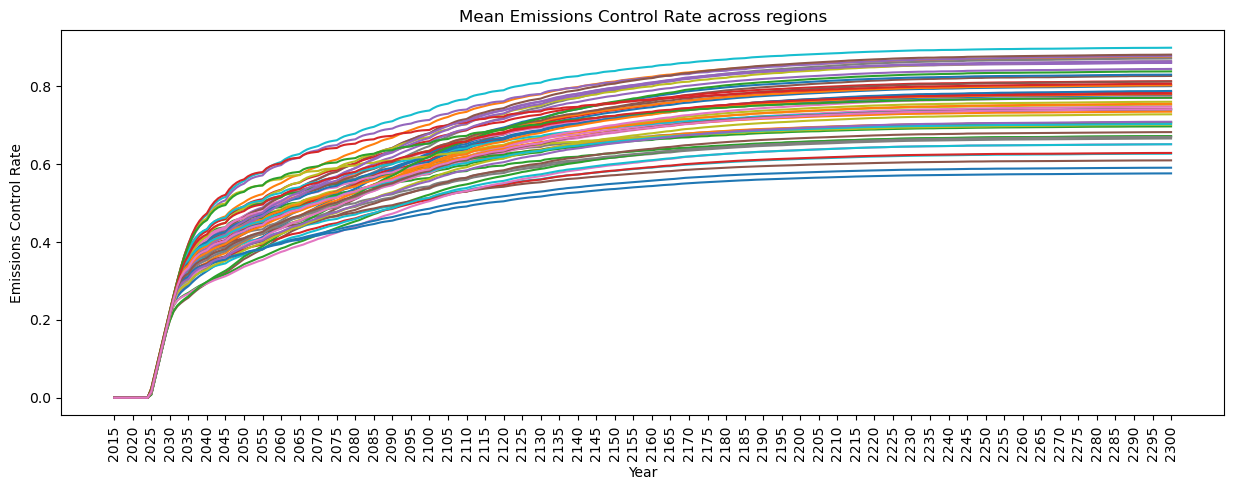

In [7]:
constrained_emission_control_rate = []
# Plot emissions_control_rate for each region in subplots
import matplotlib.pyplot as plt
# Average emissions_control_rate across all scenarios
average_emissions_control_rate = np.mean(constrained_emission_control_rate, axis=2)

# Convert average_emissions_control_rate timestep to year
average_emissions_control_rate_df = pd.DataFrame(average_emissions_control_rate)
average_emissions_control_rate_df.columns = [time_horizon.timestep_to_year(i, 1) for i in range(286)]

# Plot all the regions in a single plot
plt.figure(figsize=(15,5))

# Get region names
regions_str = data_loader.REGION_LIST

for i in range(len(regions_str)):
    plt.plot(average_emissions_control_rate_df.iloc[i, :])

#plt.legend(regions_str)
# Add fine grid with 1 year interval
plt.xticks(np.arange(2015, 2301, 5))

# Rotate x labels for better visibility
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Emissions Control Rate')
plt.title('Mean Emissions Control Rate across regions')
plt.show()



# Plot the average emissions_control_rate for each region
# plt.figure(figsize=(15, 20))

# for i in range(57):
#     plt.subplot(10, 6, i+1)
#     plt.plot(average_emissions_control_rate[i, :])
#     plt.title(data_loader.REGION_LIST[i])
#     plt.xlabel('Year')
#     plt.ylabel('Emissions Control Rate')

# plt.tight_layout()
# plt.show()


In [3]:
# Converting byte string to string
from src.util.data_loader import DataLoader
data_loader = DataLoader()
regionlist = data_loader.REGION_LIST
regionlist = [region.decode() for region in regionlist]

/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_3493/2637192622.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = cm.get_cmap('Spectral')(np.linspace(0, 1, num_lines))


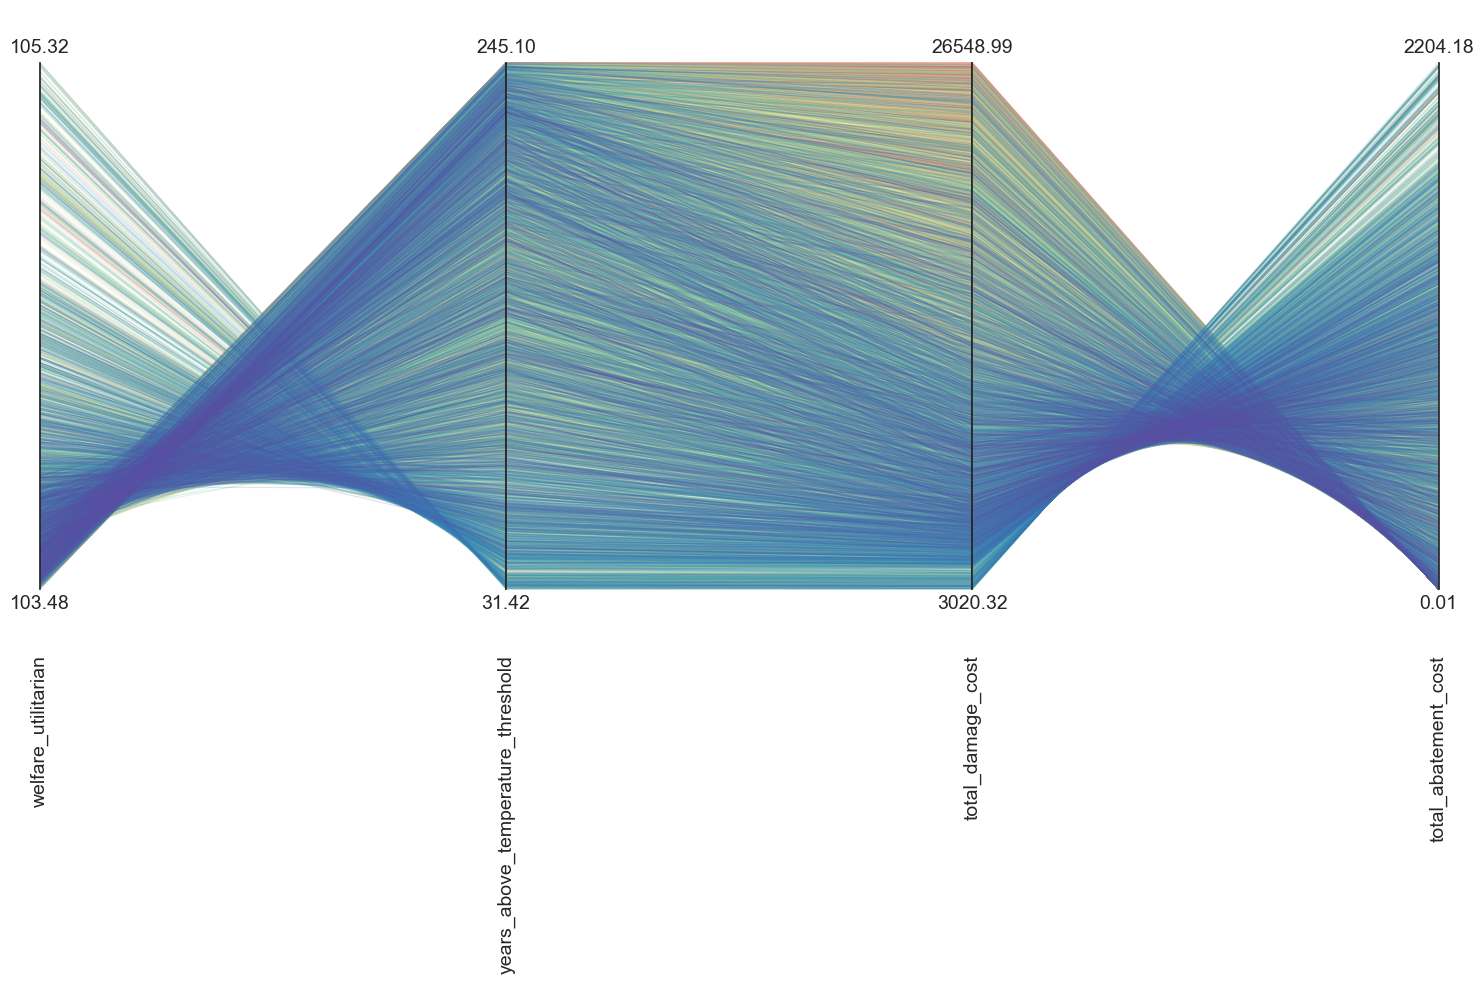

In [18]:
df_to_plot = objective_df
# Get limits for each objective
limits = parcoords.get_limits(df_to_plot)
axes = parcoords.ParallelAxes(limits)
# Define the number of lines
num_lines = len(df_to_plot)

# Define the color spectrum palette
color_palette = cm.get_cmap('Spectral')(np.linspace(0, 1, num_lines))

# Rotate the labels of the axis to 45 degrees



# Plot the data
for i in range(num_lines):
    axes.plot(df_to_plot.iloc[i], color=color_palette[i], linewidth=0.8, alpha=0.2)


In [1]:

from src.util.enumerations import WelfareFunction, get_welfare_function_name
from config.default_parameters import SocialWelfareDefaults


# TODO should have a configuration file for optimizations
social_welfare_function = WelfareFunction.EGALITARIAN
social_welfare_function = WelfareFunction.PRIORITARIAN
social_welfare_function = WelfareFunction.UTILITARIAN
social_welfare_function = WelfareFunction.SUFFICIENTARIAN
# Get Social Welfare Defaults
social_welfare_defaults = SocialWelfareDefaults().get_defaults(
    social_welfare_function.value[1]
)

elasticity_of_marginal_utility_of_consumption = social_welfare_defaults["elasticity_of_marginal_utility_of_consumption"]
pure_rate_of_social_time_preference = social_welfare_defaults["pure_rate_of_social_time_preference"]
inequality_aversion = social_welfare_defaults["inequality_aversion"]
sufficiency_threshold = social_welfare_defaults["sufficiency_threshold"]
egality_strictness = social_welfare_defaults["egality_strictness"]

print(social_welfare_function.value[1])
nfe = 5000

filename = f"{social_welfare_function.value[1]}_{nfe}.tar.gz"
print(filename)



SUFFICIENTARIAN
SUFFICIENTARIAN_5000.tar.gz


[0.         0.91512559 0.42728242 0.17114117]
[0.         0.90608571 0.46236145 0.14580305]
[0.51       0.43045587 0.10712059 0.65837402]
[0.51       0.50557841 0.11372936 0.65996208]


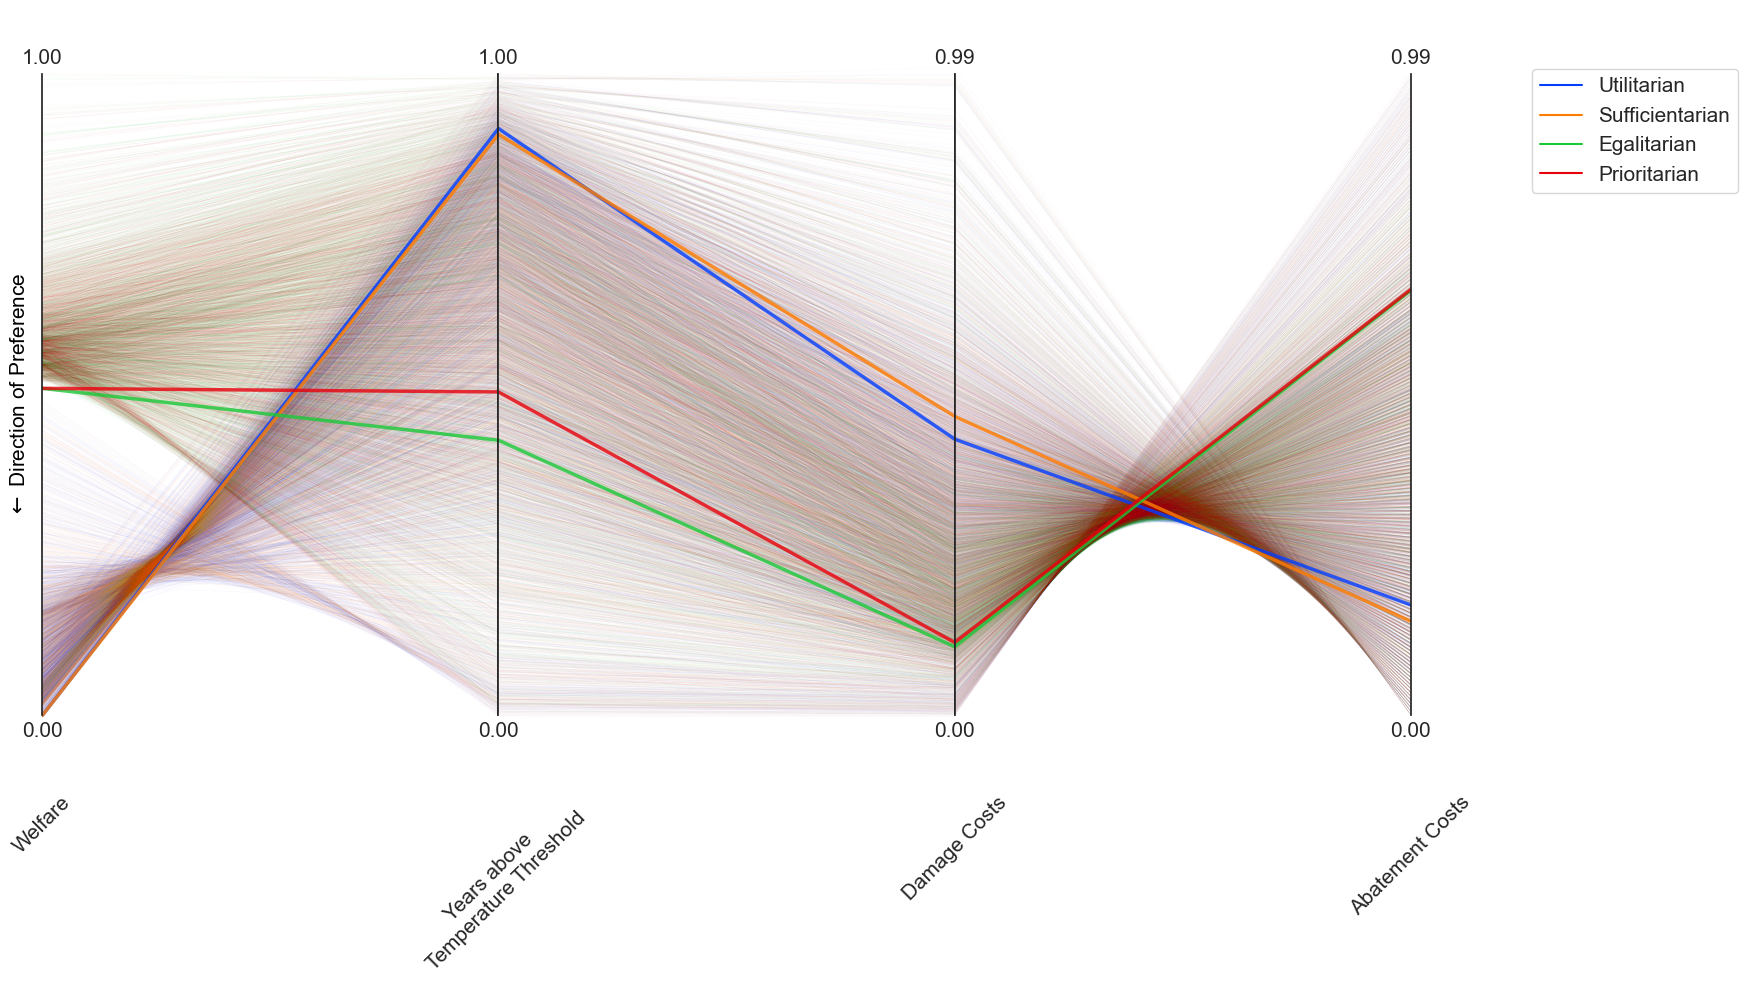

In [5]:
# 100k Viz
from src.util.visualizer import visualize_tradeoffs
visualize_tradeoffs(
    path_to_data='data/optimized_rbf_weights/tradeoffs',
    path_to_output="data/plots",
    input_data = ["UTIL_100049.csv", "SUFF_102924.csv", "EGAL_101948.csv", "PRIOR_101765.csv"],
    column_labels = ["Welfare", "Years above \nTemperature Threshold", "Damage Costs", "Abatement Costs"],
    legend_labels = ["Utilitarian", "Sufficientarian", "Egalitarian", "Prioritarian"],
    linewidth=0.4,
    alpha=0.03,
    feature_adjustment_value=300,
    show_best_solutions=True,
    )

In [1]:
import pandas as pd
"""
10K
            Max                Min
    Util:   103.81228045415136 103.4844246523926
    Egal:   414.02329209797296 411.62632633121007
    Prior:  414.0439514015804  411.5511882634973
    Suff:   103.79372232319255 103.4903588180675

100K
            Max                Min
    Util:   103.83587393570603 103.48137813079882
    Egal:   413.998482125867   411.38869134509866
    Prior:  414.0583351228716  411.3949039937641
    Suff:   103.83485353599104 103.48622581339748    
"""

input_data = ["UTIL_10158.csv", "EGAL_10164.csv", "PRIOR_10049.csv", "SUFF_10130.csv"]
input_data_100k = ["UTIL_100049.csv", "EGAL_101948.csv", "PRIOR_101765.csv", "SUFF_102924.csv"]

df = pd.read_csv('data/optimized_rbf_weights/tradeoffs/'+input_data_100k[0])
df = df.iloc[:, -4:]

min_welfare_index = df['welfare_utilitarian'].idxmin()

max_val = df.iloc[:, 0].max()
min_val = df.iloc[:, 0].min()

# Arrange the data prior in descending order of welfare_utilitarian
# df = df.sort_values(by='welfare_utilitarian', ascending=False)
# df.columns[0]
df = df.sort_values(by=df.columns[0], ascending=True)
print("Max & Min: ", max_val , min_val)
print("index: ", min_welfare_index)

Max & Min:  103.83587393570603 103.48137813079882
index:  1033


In [1]:
from src.util.enumerations import *

ssp_rcp_string_list = Scenario.get_ssp_rcp_strings()
ssp_rcp_string_list


['SSP1-RCP1.9',
 'SSP1-RCP2.6',
 'SSP2-RCP4.5',
 'SSP3-RCP7.0',
 'SSP4-RCP3.4',
 'SSP4-RCP6.0',
 'SSP5-RCP3.4-overshoot',
 'SSP5-RCP8.5']

SSP119
5.0225364295858865
SSP126
5.006113179818695
SSP245
6.95836550186995
SSP370
8.411998592245883
SSP434
6.392351190982855
SSP460
6.48100109945816
SSP534
8.86614531022612
SSP585
9.7087207697446


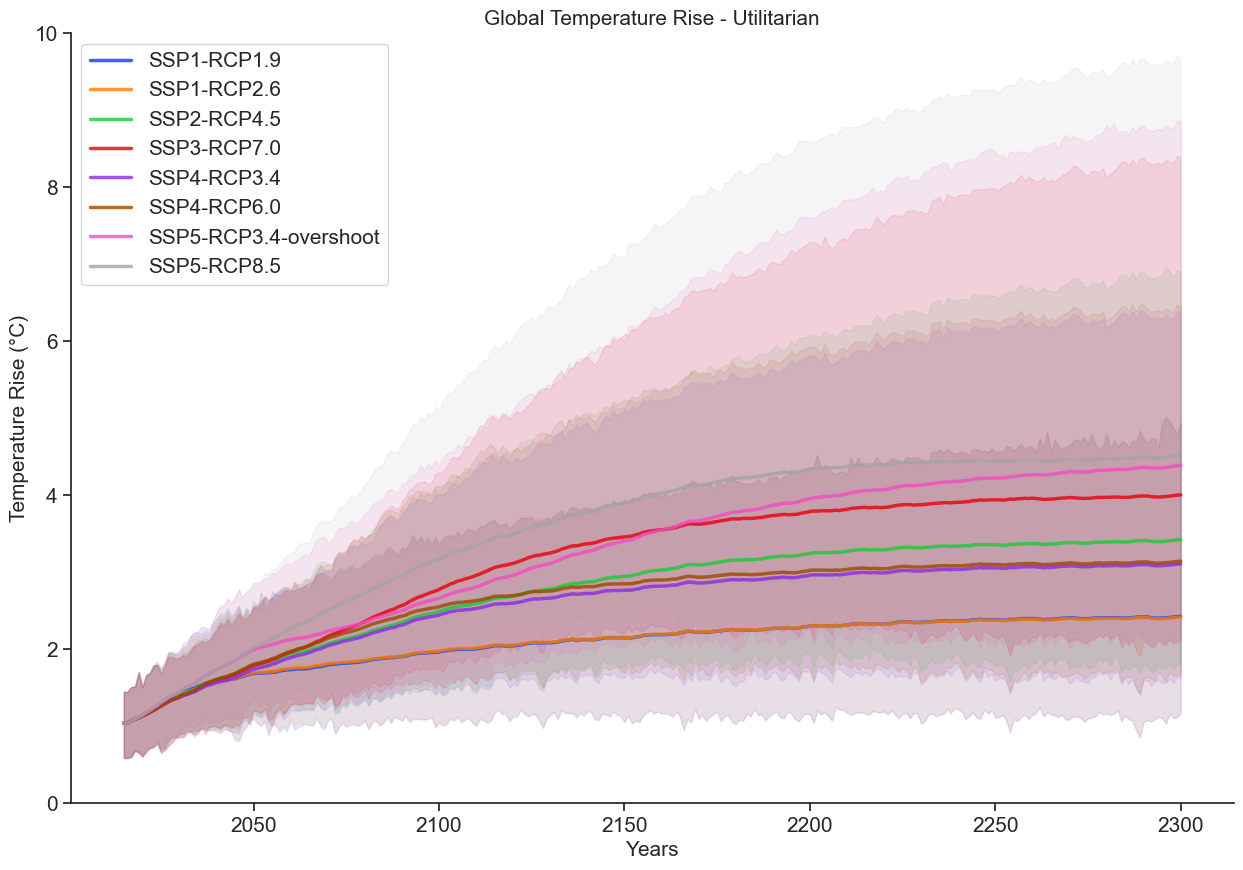

In [4]:
from src.util.visualizer import plot_timeseries

plot_timeseries(

    path_to_data="data/reevaluation",
    path_to_output="./data/plots",
    x_label="Years",
    y_label="Temperature Rise (°C)",
    variable_name="global_temperature",
    input_data=["UTIL_100049.pkl", 
                # "EGAL_101948.pkl", 
                # "PRIOR_101765.pkl", 
                # "SUFF_102924.pkl",
                ],
    output_titles=["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    main_title="Global Temperature Rise - ",
    yaxis_lower_limit=0,
    yaxis_upper_limit=10,
    alpha=0.1,
    linewidth=2.5,

)

In [1]:
from src.util.visualizer import process_country_data_for_choropleth_plot, plot_choropleth

plot_choropleth(
    variable_name="constrained_emission_control_rate",
    path_to_data="data/reevaluation/",
    path_to_output="./data/plots",
    year_to_visualize=2100,
    input_data=[
        "UTIL_100049.pkl",
        "EGAL_101948.pkl",
        "PRIOR_101765.pkl",
        "SUFF_102924.pkl",
    ],
    output_titles=["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
    title="Mitigation Burden Distribution in ",
    data_label="Emission Control Rate",
    colourmap="matter",
    legend_label="% Mitigation\n",

)

/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [16]:
import plotly.express as px
import pandas as pd

title='Mitigation Burden Distribution in ' + str(year_to_visualize) 


fig = px.choropleth(df, locations='CountryCode', color='Emission Control Rate', hover_name='CountryName',
                    projection='natural earth', 
                    title=title, 
                    height=700, width=1200,
                    color_continuous_scale='matter',
                    )


# Update the layout
fig.update_layout(title={'text': title,'xanchor': 'center', 'yanchor': 'top', 'x': 0.5, 'y': 0.95}, coloraxis_colorbar=dict(title="% Mitigation\n"), coloraxis_colorbar_x=-0.1)


fig.show()

In [2]:
from src.util.enumerations import Scenario
from src.util.model_time import TimeHorizon
import numpy as np
import pandas as pd
from src.util.data_loader import DataLoader
from src.util.output_data_processor import reevaluated_optimal_policy_variable_extractor

scenario_list = list(Scenario.__members__.keys()) # ['SSP119', 'SSP126', 'SSP245', 'SSP370', 'SSP434', 'SSP460', 'SSP534', 'SSP585']
start_year=2015
end_year=2300
data_timestep=5
timestep=1

data_loader = DataLoader()
region_list = data_loader.REGION_LIST

# Set the time horizon
time_horizon = TimeHorizon(
    start_year=start_year,
    end_year=end_year,
    data_timestep=data_timestep,
    timestep=timestep,
)

list_of_years = time_horizon.model_time_horizon
columns = list_of_years

reevaluated_optimal_policy_variable_extractor(
    scenario_list=scenario_list, #['SSP119', 'SSP126', 'SSP245', 'SSP370', 'SSP434', 'SSP460', 'SSP534', 'SSP585'],
    region_list=region_list,
    list_of_years=list_of_years,
    path_to_data="data/reevaluation",
    path_to_output="data/reevaluation",
    variable_name='net_economic_output',
    data_shape=3,
    no_of_ensembles=1001,
    input_data= ["UTIL_100049.pkl", 
            # "EGAL_101948.pkl", 
            # "PRIOR_101765.pkl", 
            # "SUFF_102924.pkl",
            ],
    output_file_names=["Utilitarian", "Egalitarian", "Prioritarian", "Sufficientarian"],
)



UTIL_100049.pkl 0 <class 'str'> UTIL_100049.pkl
SSP119
File saved as Utilitarian_SSP119_net_economic_output.pkl at location data/reevaluation
SSP126
File saved as Utilitarian_SSP126_net_economic_output.pkl at location data/reevaluation
SSP245
File saved as Utilitarian_SSP245_net_economic_output.pkl at location data/reevaluation
SSP370
File saved as Utilitarian_SSP370_net_economic_output.pkl at location data/reevaluation
SSP434
File saved as Utilitarian_SSP434_net_economic_output.pkl at location data/reevaluation
SSP460
File saved as Utilitarian_SSP460_net_economic_output.pkl at location data/reevaluation
SSP534
File saved as Utilitarian_SSP534_net_economic_output.pkl at location data/reevaluation
SSP585
File saved as Utilitarian_SSP585_net_economic_output.pkl at location data/reevaluation


In [3]:
import pickle
# Load pickle file named UTIL_100049_SSP245_net_economic_output.pkl 
with open("data/reevaluation/UTIL_100049_SSP245_global_temperature.pkl", "rb") as f:
    data = pickle.load(f)